In [1]:
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [2]:
from utils.common import (
    sigmoid, 
    pad_column_name
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, FIRST_FEATURES,
    RANGE_FEATURES, VELOCITY_FEATURES, SPEED_FEATURES
)

In [3]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"
EXP_PATH = "../experiments"

In [4]:
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

In [5]:
%load_ext autoreload
%autoreload

### Read Data

In [6]:
EXP_FULL_PATH = "../experiments/lgbm_gbdt_exp2"

In [7]:
train_val = read_file(f"{EXP_FULL_PATH}/train_val.pkl")

Shape of data: (458913, 766)


In [8]:
validation_indices = joblib.load(f'{EXP_FULL_PATH}/5_fold_val_indices.pkl')

In [9]:
model_paths = [file for file in sorted(os.listdir(f"{EXP_FULL_PATH}/models")) if file.startswith("model")]

In [10]:
models = {}
feature_imps = []
for i, model_path in enumerate(model_paths):
    models[i] = joblib.load(f"{EXP_FULL_PATH}/models/{model_path}")
    feature_imps.append(
        pd.DataFrame(
            {
                "feature": models[i].feature_name_, 
                f"importance{i}": models[i].feature_importances_
            }
        ).set_index("feature")
    )

In [11]:
feature_imp_df = pd.concat(feature_imps, axis=1)
feature_imp_df["average_importance"] = feature_imp_df.mean(axis=1)
feature_imp_df = feature_imp_df.sort_values("average_importance", ascending=False)

In [12]:
noob_features_df = feature_imp_df["average_importance"].nsmallest(int(feature_imp_df.shape[0] * 0.04))
noob_features = noob_features_df.index.tolist()

In [16]:
top_features_df = feature_imp_df["average_importance"].nlargest(int(feature_imp_df.shape[0] * 0.9))
top_features = top_features_df.index.tolist()

In [20]:
pd.Series([f.split("_")[-1] for f in top_features]).value_counts()

avg         117
last        111
max          90
velocity     86
range        76
first        71
min          68
speed        68
dummy         1
dtype: int64

In [89]:
pd.Series(top_features, name="feature").to_csv("top_features.csv", index=False)

In [67]:
# used_features = set(feature_imp_df.index.tolist())

In [61]:
mean_features = pad_column_name(MEAN_FEATURES, suffix="_avg")
min_features = pad_column_name(MIN_FEATURES, suffix="_min")
max_features = pad_column_name(MAX_FEATURES, suffix="_max")
last_features = pad_column_name(LAST_FEATURES, suffix="_last")
first_features = pad_column_name(FIRST_FEATURES, suffix="_first")

In [62]:
range_features = pad_column_name(RANGE_FEATURES, suffix="_range")
velocity_features = pad_column_name(VELOCITY_FEATURES, suffix="_velocity")
speed_features = pad_column_name(SPEED_FEATURES, suffix="_speed")

In [63]:
all_features = (
    mean_features + min_features + max_features + last_features + first_features
    + range_features + velocity_features + speed_features
)

In [64]:
len(all_features)

772

In [65]:
set(top_features) - set(all_features)

set()

152

In [72]:
top_features

['D_46_last',
 'D_43_last',
 'S_3_last',
 'D_43_avg',
 'P_3_last',
 'P_2_last',
 'D_48_velocity',
 'D_43_max',
 'D_46_min',
 'S_3_avg',
 'B_5_last',
 'D_48_last',
 'D_46_avg',
 'P_3_min',
 'R_27_min',
 'P_3_max',
 'B_3_last',
 'D_43_min',
 'D_48_range',
 'D_52_speed',
 'D_62_min',
 'S_9_avg',
 'R_27_avg',
 'D_46_max',
 'D_43_range',
 'R_27_max',
 'D_46_first',
 'P_2_avg',
 'D_77_range',
 'P_2_min',
 'R_27_first',
 'B_17_last',
 'R_27_range',
 'D_144_speed',
 'S_9_min',
 'S_3_min',
 'S_7_last',
 'R_27_last',
 'D_48_speed',
 'P_2_velocity',
 'D_144_first',
 'D_55_speed',
 'D_43_first',
 'D_62_speed',
 'S_3_range',
 'S_3_first',
 'D_46_range',
 'P_3_avg',
 'P_2_first',
 'S_7_avg',
 'P_3_range',
 'S_9_last',
 'D_52_velocity',
 'S_12_avg',
 'S_7_min',
 'R_1_last',
 'P_3_first',
 'D_121_velocity',
 'P_2_speed',
 'B_4_last',
 'D_61_last',
 'D_61_speed',
 'S_12_min',
 'D_62_velocity',
 'D_133_first',
 'R_27_velocity',
 'D_144_velocity',
 'D_102_velocity',
 'D_77_min',
 'S_7_max',
 'D_61_veloci

In [ ]:
feature_imp_df = feature_imp_df.loc[feature_imp_df["average_importance"] > 0]
feature_imp_subset = feature_imp_df.loc[feature_imp_df["average_importance"] > 200].reset_index()

In [ ]:
# feature_imp_subset.loc[feature_imp_subset["feature"].str.contains("last")].sort_values("feature")

In [ ]:
t = feature_imp_subset.copy()

In [ ]:
t.loc[t["feature"] == "D_128_first"]

In [ ]:
# feature_imp_df.index.tolist()

In [ ]:
feature_list = feature_imp_df.index.tolist()
len(feature_list)

In [ ]:
temp_train_val = train_val.copy()
for i, indices in enumerate(validation_indices):
    temp_model = models[i]
    temp_val = temp_train_val.loc[indices, temp_model.feature_name_]
    temp_train_val.loc[indices, "score"] = temp_model.predict_proba(temp_val, raw_score=True)
original_score = amex_metric(temp_train_val["target"], temp_train_val["score"])

In [ ]:
original_score

In [ ]:
simulated_score_list = []
for feature in feature_list[::-1]:
    temp_train_val = train_val.copy()
    temp_train_val[feature] = np.nan
    for i, indices in enumerate(validation_indices):
        temp_model = models[i]
        temp_val = temp_train_val.loc[indices, temp_model.feature_name_]
        temp_train_val.loc[indices, "score"] = temp_model.predict_proba(temp_val, raw_score=True)
    simulated_score = amex_metric(temp_train_val["target"], temp_train_val["score"])
    simulated_score_list.append(simulated_score)
    if simulated_score >= original_score:
        sign = "+"
    else:
        sign = ""
    if abs(simulated_score - original_score) >= 1e-4:
        print(feature, f" {sign}{(simulated_score - original_score):.4f}")
    print(f"{feature} done")
    del temp_train_val
    gc.collect()

In [ ]:
def process_test_data(df):
    last_df = df.loc[df["row_number"] == 1]
    last_df = last_df.set_index("customer_ID")
    last_df = last_df.iloc[:, 3:]
    last_df = last_df.rename(columns={f: f"{f}_last" for f in last_df.columns})
    gc.collect()
    
    first_df = df.loc[df["row_number_inv"] == 1]
    first_df = first_df.set_index("customer_ID")
    first_df = first_df.iloc[:, 3:]
    first_df = first_df.rename(columns={f: f"{f}_first" for f in first_df.columns})
    gc.collect()
    
    cid = pd.Categorical(df.pop('customer_ID'), ordered=True)
    last = (cid != np.roll(cid, -1)) # mask for last statement of every customer
    first = (cid != np.roll(cid, 0))
    numeric_columns = set(df.select_dtypes(("float32", "int8", "int16")).columns.tolist()) - set(CATEGORY_COLUMNS)
    all_columns = numeric_columns.union(CATEGORY_COLUMNS)
    
    avg = (df
      .groupby(cid)
      .mean()[numeric_columns]
      .rename(columns={f: f"{f}_avg" for f in numeric_columns})
    )
    gc.collect()
    
    min_ = (df
      .groupby(cid)
      .min()[numeric_columns]
      .rename(columns={f: f"{f}_min" for f in numeric_columns})
    )
    gc.collect()
    
    max_ = (df
      .groupby(cid)
      .max()[numeric_columns]
      .rename(columns={f: f"{f}_max" for f in numeric_columns})
    )
    gc.collect()
    
    all_df = pd.concat(
        [
            avg, 
            min_, 
            max_, 
            last_df, 
            first_df
        ], 
        axis=1
    )
    
    del avg, min_, max_, last_df, first_df
    for col in tqdm(numeric_columns):
        all_df[f"{col}_range"] = all_df[f"{col}_max"] - all_df[f"{col}_min"]
        all_df[f"{col}_speed"] = all_df[f"{col}_last"] - all_df[f"{col}_first"]
        all_df[f"{col}_velocity"] = all_df[f"{col}_speed"] / (all_df[f"{col}_range"] + all_df[f"{col}_avg"])
        
    # first_to_drop = [col for col in train.columns if col.endswith("_first") and col.replace("_first", "") not in FIRST_FEATURES]
    # train = train.drop(columns=first_to_drop, errors="ignore")
    # range_to_drop = [col for col in train.columns if col.endswith("_range") and col.replace("_range", "") not in RANGE_FEATURES]
    # train = train.drop(columns=range_to_drop, errors="ignore")
    # speed_to_drop = [col for col in train.columns if col.endswith("_speed") and col.replace("_speed", "") not in SPEED_FEATURES]
    # train = train.drop(columns=speed_to_drop, errors="ignore")
    # velocity_to_drop = [col for col in train.columns if col.endswith("_velocity") and col.replace("_velocity", "") not in VELOCITY_FEATURES]
    # train = train.drop(columns=velocity_to_drop, errors="ignore")
    return all_df

In [ ]:
test = read_file(f"{RAW_TEST_PICKLE_PATH}/test_data.pkl")

In [ ]:
test.loc[test["row_number"] > 12]

In [ ]:
test_agg = process_test_data(test)

In [ ]:
test_agg.head()

In [ ]:
del test

In [ ]:
for i, model in enumerate(models.values()):
    model_input = test_agg.loc[:, model.feature_name_]
    test_agg.loc[:, f"score{i}"] = model.predict_proba(model_input, raw_score=True)

In [ ]:
test_agg.head()

In [31]:
new_result_sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission19_0.796.csv")

In [32]:
old_result_sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission17_0.796.csv")

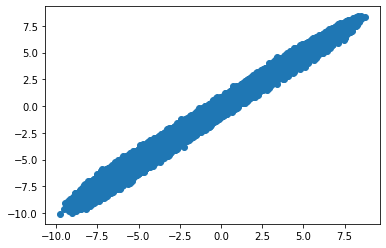

In [33]:
plt.scatter(old_result_sub["prediction"], new_result_sub["prediction"])

In [34]:
np.corrcoef(old_result_sub["prediction"], new_result_sub["prediction"])

array([[1.        , 0.99693857],
       [0.99693857, 1.        ]])

In [37]:
merged_result = new_result_sub.merge(old_result_sub, on="customer_ID", how="left")

In [40]:
merged_result["x_positive"] = (merged_result["prediction_x"] >= 0)

In [41]:
merged_result["y_positive"] = (merged_result["prediction_y"] >= 0)

(244720, 5)

In [51]:
neg_neg_indices = merged_result.loc[(~merged_result["x_positive"]) & (~merged_result["y_positive"])].index

In [57]:
merged_result.loc[neg_neg_indices, "prediction"] = merged_result.loc[neg_neg_indices, :].min(axis=1)

In [58]:
pos_pos_indices = merged_result.loc[(merged_result["x_positive"]) & (merged_result["y_positive"])].index

In [59]:
merged_result.loc[pos_pos_indices, "prediction"] = merged_result.loc[pos_pos_indices, :].max(axis=1)

In [72]:
merged_result["prediction"].isnull().sum()

0

In [71]:
merged_result.loc[merged_result["prediction"].isnull(), "prediction"] = \
(merged_result.loc[merged_result["prediction"].isnull(), "prediction_x"] + \
merged_result.loc[merged_result["prediction"].isnull(), "prediction_y"]) / 2

In [76]:
merged_result = merged_result.drop(columns=["prediction_x", "prediction_y", "x_positive", "y_positive"])

In [77]:
merged_result.to_csv(f"{SUBMISSION_DATA_PATH}/submission23.csv", index=False)

In [20]:
new_result_sub["prediction"] = np.max([new_result_sub["prediction"].values, old_result_sub["prediction"].values], axis=0)

In [27]:
new_result_sub["prediction"] += old_result_sub["prediction"]

In [28]:
new_result_sub["prediction"] /= 2

In [30]:
new_result_sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission22.csv", index=False)

In [ ]:
result_sub = test_agg.loc[:, [c for c in test_agg.columns if c.startswith("score")]].mean(axis=1).reset_index()

In [ ]:
result_sub.columns = ["customer_ID", "prediction"]

In [ ]:
result_sub.to_csv("submission20.csv", index=False)

In [ ]:
single_record_index = test_agg.loc[test_agg["num_records"] == 1].index.tolist()

In [ ]:
final_df13 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission13_0.796.csv")
final_df13["prediction_13"] = sigmoid(final_df13["prediction"])
final_df13 = final_df13.drop(columns="prediction")

In [ ]:
final_df16 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission16_0.782.csv")
final_df16["prediction_16"] = sigmoid(final_df16["prediction"])
final_df16 = final_df16.drop(columns="prediction")

In [ ]:
mega_df = final_df13.merge(final_df16, on="customer_ID", how="left")

In [ ]:
mega_df.loc[:, "prediction"] = (
    mega_df.loc[:, "prediction_16"] * 0.1 \
    + mega_df.loc[:, "prediction_13"] * 0.9
)

In [ ]:
mega_df.loc[single_record_index, "prediction"] = (
    mega_df.loc[single_record_index, "prediction_16"] * 0.8 \
    + mega_df.loc[single_record_index, "prediction_13"] * 0.2
)

In [ ]:
mega_df = mega_df.drop(columns=["prediction_13", "prediction_16"])

In [ ]:
mega_df["prediction"] = 0.55 * mega_df["prediction_x"] + 0.45 * mega_df["prediction_y"]
mega_df = mega_df.drop(columns=["prediction_x", "prediction_y"])

In [ ]:
mega_df.to_csv(f"{SUBMISSION_DATA_PATH}/submission18.csv", index=False)

### Read Data

In [ ]:
df = read_file(f"{RAW_TEST_PARQUET_PATH}/test_data5.parquet")

In [ ]:
df.columns

In [ ]:
df["day_of_week"] = df["S_2"].dt.day_of_week.astype("category")
df["D_66"] = df["D_66"].fillna(0)
df["D_116"] = df["D_116"].fillna(0)

In [ ]:
df.loc[:, CATEGORY_COLUMNS] = df.loc[:, CATEGORY_COLUMNS].astype(str).astype("category")

In [ ]:
df["row_number"] = df.groupby("customer_ID")["S_2"].rank(method="first", ascending=False).astype(int)

In [ ]:
df_list = []
for row in range(1, 4):
    df_subset = df.loc[df["row_number"] == row]
    result = pd.DataFrame(df_subset["customer_ID"].values.tolist(), columns=["customer_ID"])
    for i in tqdm(range(1, 6)):
        lgbm_clf = joblib.load(f"{MODELS_PATH}/lag{row}_models/model_{i}.pkl")
        result[f"raw_score{i}"] = lgbm_clf.predict_proba(df_subset.loc[:, lgbm_clf.feature_name_], raw_score=True)
    result[f"model_{row}"] = result[[f"raw_score{k}" for k in range(1, 6)]].mean(axis=1)
    df_list.append(result.drop(columns=[f"raw_score{k}" for k in range(1, 6)]))

In [ ]:
final_df5 = df_list[0].merge(
    df_list[1], on="customer_ID", how="left"
).merge(
    df_list[2], on="customer_ID", how="left"
)

In [ ]:
final_df = pd.concat([final_df1, final_df2, final_df3, final_df4, final_df5], ignore_index=True)
del final_df1, final_df2, final_df3, final_df4, final_df5

In [ ]:
final_df.shape

In [ ]:
# final_df.to_csv(f"{EVALUATION_DATA_PATH}/3_lag_models_test_raw_score.csv", index=False)

In [ ]:
final_df = pd.read_csv(f"{EVALUATION_DATA_PATH}/3_lag_models_test_raw_score.csv")

In [ ]:
for i in range(1, 4):
    final_df[f"model_{i}"] = sigmoid(final_df[f"model_{i}"])

In [ ]:
all3 = final_df.loc[~final_df["model_3"].isnull()]

In [ ]:
all3["prediction"] = 1.2 * all3["model_1"] + (-0.1) * all3["model_2"] + (-0.1) * all3["model_3"]

In [ ]:
temp = final_df.drop(index=all3.index)
just2 = temp.loc[~temp["model_2"].isnull()]

In [ ]:
just2["prediction"] = 1.1 * just2["model_1"] + (-0.1) * just2["model_2"] 

In [ ]:
just1 = temp.drop(index=just2.index)

In [ ]:
just1["prediction"] = just1["model_1"]

In [ ]:
submission = pd.concat(
    [all3, just2, just1], 
    ignore_index=True
).sort_values(by="customer_ID").loc[:, ["customer_ID", "prediction"]].reset_index(drop=True)

In [ ]:
submission.to_csv(f"{SUBMISSION_DATA_PATH}/submission12.csv", index=False)

### Load Model

In [ ]:
result_df_list = []
for j in range(1, 6):
    test_data = read_file(f"{PROCESSED_DATA_PATH}/test_agg{j}.parquet")
    for col in test_data.select_dtypes("category").columns:
        if col not in ["D_63_last", "D_64_last"]:
            test_data.loc[:, col] = test_data.loc[:, col].astype(float)\
    temp = pd.DataFrame(dict(customer_ID=test_data["customer_ID"]))
    for i in tqdm(range(1, 11)):
        lgbm_clf = joblib.load(f"{MODELS_PATH}/lgbm_models/model_{i}.pkl")
        temp[f"raw_score{i}"] = lgbm_clf.predict_proba(test_data.loc[:, lgbm_clf.feature_name_], raw_score=True)
    result_df_list.append(temp)

In [ ]:
master_df = pd.concat(result_df_list, ignore_index=True)

In [ ]:
master_df["prediction"] = master_df[get_cols(master_df, "raw_score")].mean(axis=1)

In [ ]:
master_df[["customer_ID", "prediction"]].to_csv(f"{SUBMISSION_DATA_PATH}/submission9.csv", index=False)

In [ ]:
# master_df.to_csv(f"{EVALUATION_DATA_PATH}/test_raw_score.csv", index=False)

In [ ]:
# rule_df = pd.read_csv(f"{EVALUATION_DATA_PATH}/rule_df.csv")
# exp_top_four_df = master_df.sort_values(by="prediction", ascending=False).iloc[:180000, :]
# filter_df = test_data.loc[test_data["customer_ID"].isin(exp_top_four_df["customer_ID"].tolist())]

In [ ]:
for idx, row in rule_df.iterrows():
    col, type_, value = row
    if col in ["target", "weight"]:
        continue
    if type_ == "Minimum":
        filter_df = filter_df.loc[filter_df[col] >= value]
    else:
        filter_df = filter_df.loc[filter_df[col] <= value]

In [ ]:
master_df.head()

In [ ]:
# submission = read_file(f"{RAW_DATA_PATH}/sample_submission.csv")

In [ ]:
submission

In [ ]:
submission = submission.drop(columns="prediction")

In [ ]:
result = submission.merge(test_data[["customer_ID", "prediction"]], on="customer_ID")

### Train Val Split

In [ ]:
train, val = train_test_split(train_data, test_size=0.15, random_state=923, stratify=train_data["target"])

In [ ]:
train["target"].mean(), val["target"].mean()

In [ ]:
special_columns = ['customer_ID', 'S_2', 'target', "Date", "min_date", "max_date", "num_records", "days", "record_per_day"] \
 + get_cols(train_data, "has") + get_cols(train_data, "sign")

In [ ]:
all_cols = [c for c in train.columns if c not in special_columns]
cat_features = train.select_dtypes("category").columns.tolist()
num_features = [col for col in all_cols if col not in cat_features]

In [ ]:
len(all_cols), len(cat_features), len(num_features)

In [ ]:
train.loc[:, num_features] = train.loc[:, num_features].fillna(0)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=923)
X_res, y_res = sm.fit_resample(train.loc[:, num_features], 
                               train["target"])

In [ ]:
X_res.shape, y_res.shape

In [ ]:
X_train = train.loc[:, num_features + cat_features]
X_val = val.loc[:, num_features + cat_features]

In [ ]:
y_train = train["target"]
y_val = val["target"]

### Train once

In [ ]:
best_params = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7,
 'importance_type': 'split',
 'learning_rate': 0.07,
 'max_depth': 7,
 'min_child_samples': 50,
 'min_child_weight': 0.05,
 'min_split_gain': 0.04,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 80,
 'objective': None,
 'random_state': 1020,
 'reg_alpha': 5,
 'reg_lambda': 15,
 'silent': True,
 'subsample': 0.7,
 'subsample_for_bin': 20000,
 'subsample_freq': 5,
 'scale_pos_weight': 1}

In [ ]:
final_lgbm_clf = LGBMClassifier(**best_params)

In [ ]:
final_lgbm_clf.fit(X_train, y_train)

In [ ]:
y_train_pred = final_lgbm_clf.predict_proba(X_train)[:, 1]
y_val_pred = final_lgbm_clf.predict_proba(X_val)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred, y_val_pred], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [ ]:
imp_df = plot_feature_importance(final_lgbm_clf.feature_name_, 
                                 final_lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
# feature_imp_thr = imp_df.loc[imp_df["feature"] == "dummy"]["feature_importance"].values[0]
# feature_imp_thr

In [ ]:
selected_features = imp_df.loc[imp_df["feature_importance"] > 0]["feature"].tolist()
len(selected_features)

#### Final x2 LGBM

In [ ]:
selected_features = [col for col in selected_features if "first" not in col]
len(selected_features)

In [ ]:
final_lgbm_clf = LGBMClassifier(**best_params)

In [ ]:
X_train_ = X_train.loc[:, selected_features]
X_val_ = X_val.loc[:, selected_features]

In [ ]:
final_lgbm_clf.fit(X_train_, y_train)

In [ ]:
y_train_pred_ = final_lgbm_clf.predict_proba(X_train_)[:, 1]
y_val_pred_ = final_lgbm_clf.predict_proba(X_val_)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred_, y_val_pred_], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [ ]:
y_res_df = pd.DataFrame(y_res).reset_index(drop=True)
y_res_pred_df = pd.DataFrame(y_res_pred_).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_res_df, y_res_pred_df)

In [ ]:
y_val.values[:40]

In [ ]:
temp_ = [1 if c > 0.95 else c for c in y_val_pred_]
# temp_[:40]

In [ ]:
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
y_val_pred_df = pd.DataFrame(y_val_pred_).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_val_df, y_val_pred_df)

### END

### LGBM Model

In [ ]:
opt = BayesSearchCV(
    LGBMClassifier(random_state=1020),
    {
        'learning_rate': (0.04, 0.1),
        'num_leaves': (31, 127),
        'max_depth': (5, 20),
        'min_child_samples': (15, 63),
        'n_estimators': (80, 160),
        'subsample': (0.7, 0.9),
        'subsample_freq': (2, 5),
        'colsample_bytree': (0.6, 0.95),
        'reg_alpha': (0, 15),
        'reg_lambda': (0, 15),
        'min_split_gain': (0, 0.05),
        'scale_pos_weight': (0.1, 10)
    },
    n_iter=5,
    cv=5,
    scoring=make_scorer(fbeta_score, beta=2)
)

In [ ]:
start = time.time()
opt.fit(X_train, y_train, verbose=1)
end = time.time()
print(f"Done in {end - start:.2f} seconds")

In [ ]:
best_params = opt.best_estimator_.get_params()

In [ ]:
best_params

In [ ]:
imp_df = plot_feature_importance(final_lgbm_clf.feature_name_, 
                                 final_lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
num_features_list, train_score_list, val_score_list = [], [], []
for imp_value in tqdm(sorted(imp_df["feature_importance"].unique())):
    selected_features = imp_df.loc[imp_df["feature_importance"] > imp_value]["feature"].tolist()
    print(f"# of features: {len(selected_features)}")
    
    X_train_new = train.loc[:, selected_features]
    X_val_new = val.loc[:, selected_features]
    
    lgbm_clf = LGBMClassifier(**params)
    lgbm_clf.fit(X_train_new, y_train)
    
    y_train_pred = lgbm_clf.predict_proba(X_train_new)[:, 1]
    y_val_pred = lgbm_clf.predict_proba(X_val_new)[:, 1]
    
    y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
    y_train_pred_df = pd.DataFrame(y_train_pred).rename(columns={0: "prediction"})
    y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
    y_val_pred_df = pd.DataFrame(y_val_pred).rename(columns={0: "prediction"})
    
    train_score = amex_metric(y_train_df, y_train_pred_df)
    val_score = amex_metric(y_val_df, y_val_pred_df)
    num_features_list.append(len(selected_features))
    train_score_list.append(train_score)
    val_score_list.append(val_score)

In [ ]:
train_scores = [i[0] for i in train_score_list]
val_scores = [i[0] for i in val_score_list]

In [ ]:
eval_df = pd.DataFrame(dict(num_feature=num_features_list, 
                            train_score=train_scores, 
                            val_score=val_scores)).iloc[:-10]

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(eval_df["num_feature"], eval_df["train_score"], label="Train")
plt.plot(eval_df["num_feature"], eval_df["val_score"], label="Validation")
plt.legend()
plt.show()

### LGBM Error Analysis

In [ ]:
X_validation = X_val_.reset_index(drop=True)

In [ ]:
top4_pct_df, gini_df = get_final_metric_df(X_validation, y_val_df, y_val_pred_df)

In [ ]:
failed_top4_pct_indices = top4_pct_df.loc[(top4_pct_df["is_cutoff"] == 1) & (top4_pct_df["target"] == 0)].index

In [ ]:
# failed_top4_pct_indices

In [ ]:
failed_top4_pct_indices

In [ ]:
success_top4 = top4_pct_df.loc[~top4_pct_df.index.isin(failed_top4_pct_indices)]
failed_top4 = top4_pct_df.loc[failed_top4_pct_indices]

In [ ]:
success_top4.shape, failed_top4.shape

In [ ]:
column = "P_2_last"

In [ ]:
top4_pct_df.groupby("target")[column].mean()

In [ ]:
success_top4[column].describe()

In [ ]:
failed_top4[column].describe()

In [ ]:
# save model
# joblib.dump(final_lgbm_clf, '../models/lgbm_version1.pkl')

In [ ]:
# load model
loaded_lgbm_model = joblib.load('../models/lgbm_version1.pkl')

### Inference

In [ ]:
X_test = test_data.loc[:, selected_features]

In [ ]:
y_test_pred = loaded_lgbm_model.predict_proba(X_test)[:, 1]

In [ ]:
test_data["prediction"] = y_test_pred

In [ ]:
test_data.head()

#### Submission

In [ ]:
submission = pd.read_csv(f"{DATA_PATH}/sample_submission.csv")

In [ ]:
submission = submission.drop(columns="prediction")

In [ ]:
result = submission.merge(test_data[["customer_ID", "prediction"]], on="customer_ID")

In [ ]:
# result.to_csv(f"{SUBMISSION_DATA_PATH}/submission4.csv", index=False)